In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm.notebook import tqdm

# Задача  1. Оценка разных статистик

В лекции мы выяснили, что в эксперименте «Refactoring backend» в экспериментальной группе среднее время загрузки увеличилось, а 99% квантиль уменьшился. Проверьте значимость отличий других квантилей.

Данные эксперимента «Refactoring backend»: 2022-04-13/2022-04-13T12_df_web_logs.csv и 2022-04-13/experiment_users.csv. Эксперимент проводился с 2022-04-05 по 2022-04-12. Измерения времени обработки запросов считаем независимыми. При проверке используйте нормальный доверительный интервал.

In [9]:
web_logs = pd.read_csv('2022-04-13T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


In [10]:
users = pd.read_csv('experiment_users_13.csv')
users.head(3)

,user_id,pilot
0,c36b2e,0
1,20336e,0
2,034652,0


In [11]:
logs = web_logs.query('date >= "2022-04-05" & date < "2022-04-12"').sort_values('date')
logs.head(3)

,user_id,page,date,load_time
2111340,190c2f,m,2022-04-05 00:00:38,66.2
2111341,e65269,m,2022-04-05 00:01:25,60.0
2111342,f0d8b6,b,2022-04-05 00:01:41,72.3


In [14]:
df = pd.merge(logs, users, how='inner', on='user_id')
df.head(3)

,user_id,page,date,load_time,pilot
0,e65269,m,2022-04-05 00:01:25,60.0,1
1,e65269,m,2022-04-08 08:32:38,71.7,1
2,e65269,m,2022-04-08 08:45:27,66.1,1


In [15]:
group_a = df.query('pilot == 0').load_time.values
group_b = df.query('pilot == 1').load_time.values

In [16]:
def get_point_estimate(a_group, b_group, quantile=0.999):
    return np.quantile(b_group, quantile) - np.quantile(a_group, quantile)

def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит нормальный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    c = stats.norm.ppf(1 - alpha / 2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right

  0%|          | 0/10 [00:00<?, ?it/s]

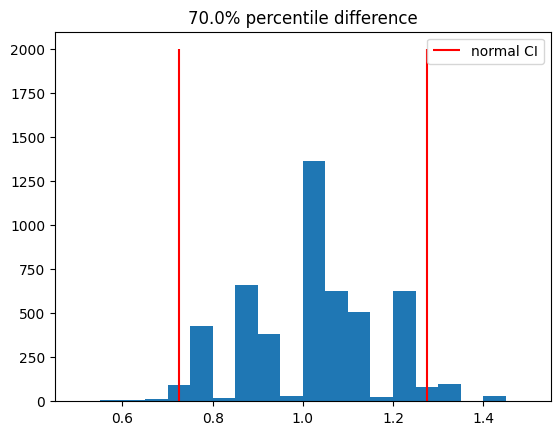

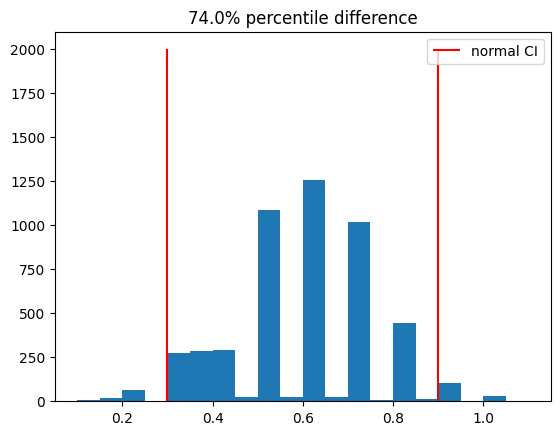

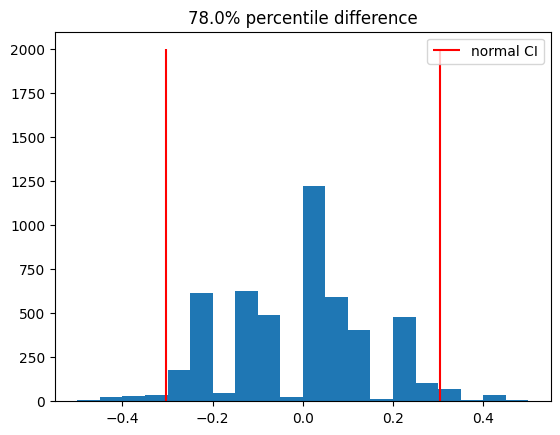

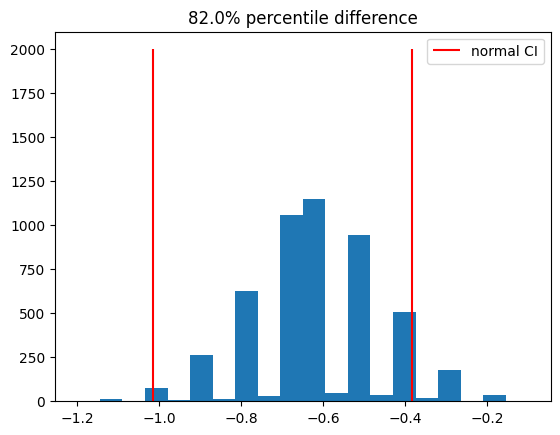

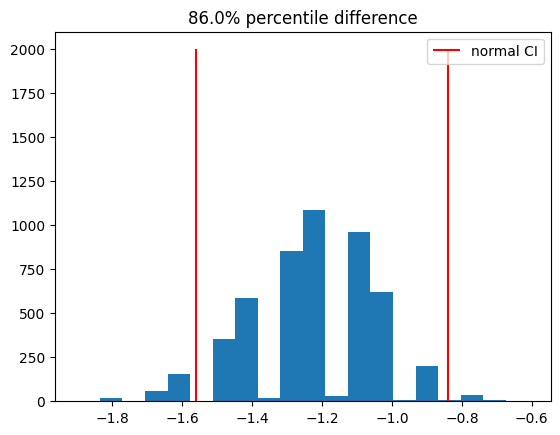

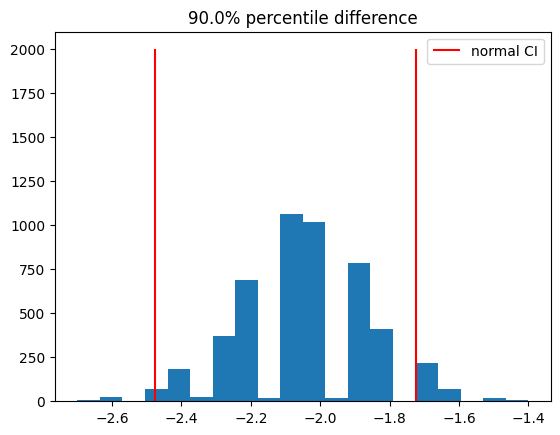

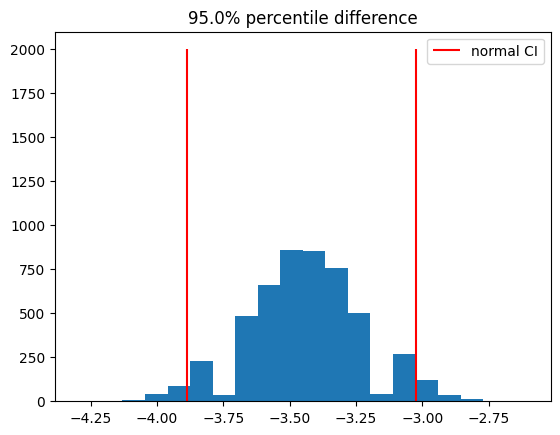

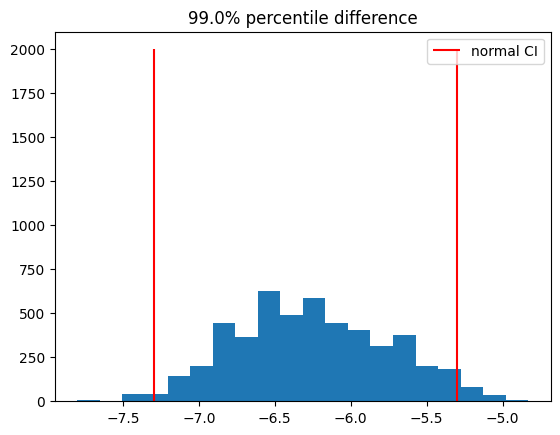

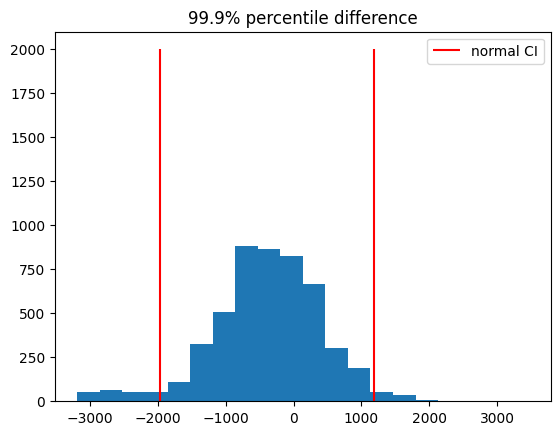

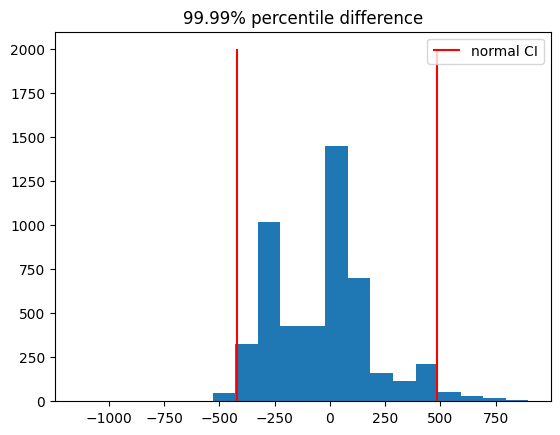

In [17]:
percentiles = [0.7, 0.74, 0.78, 0.82, 0.86, 0.90, 0.95, 0.99, 0.999, 0.9999]

for quant in tqdm(percentiles):
    
    point_estimate = get_point_estimate(group_a, group_b, quantile=quant)

    bs_point_estimates = []
    for _ in range(5000):
        bs_a = np.random.choice(group_a, size=len(group_a), replace=True)
        bs_b = np.random.choice(group_b, size=len(group_b), replace=True)
        bs_point_estimate = get_point_estimate(bs_a, bs_b, quantile=quant)
        bs_point_estimates.append(bs_point_estimate)
        
    normal_ci = get_ci_bootstrap_normal(bs_point_estimates, point_estimate)
        
    plt.title(f'{quant*100}% percentile difference')
    plt.hist(bs_point_estimates, bins=20);
    plt.vlines(normal_ci, 0, 2000, label='normal CI', color='red')
    plt.legend()
    plt.show()